In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset, VectorCGDataset, NeighbourCGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from classifier.train import training
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

dataset_dict = {c.__name__: c for c in {CGDataset, VectorCGDataset, NeighbourCGDataset}}

if vectorize:
    dataset_v = "VectorCGDataset"
elif k > 0:
    dataset_v = "NeighbourCGDataset"
else:
    dataset_v = "CGDataset"

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = dataset_dict[dataset_v](training_dir, rmsd_list, k=k)

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = dataset_dict[dataset_v](val_dir, val_rmsd, k=k)

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = dataset_dict[dataset_v](test_dir, test_rmsd, k=k)

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = dataset_dict[dataset_v](st_test_dir, st_test_rmsd, k=k)

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = dataset_dict[dataset_v](test_dir_rot, test_rmsd, k=k)

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = dataset_dict[dataset_v](fst_test_rot, st_test_rmsd, k=k)

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  Should Vector and Neighbour datasets inherit from CGDataset, to avoid code duplication?
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list** --> change from InMemoryDataset to Dataset **DONE**  --> duplicates in train rmsd list leads to discrepancy
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture?

Normalisation:
*  BatchNorm: no improvement seen, maybe with larger datasets?
*  PairNorm: Training took longer, results were nonsense
*  DiffGroupNorm: figure out how to configure it (in channels not the same as for the layers)
*  GraphNorm: Strange results, try again
*  LayerNorm: Training took longer, results were worse than without norm
*  InstanceNorm: doesnt work for 3D input?

22.06.2022 15:05:25 Creating Training Directory at 2022-06-22_15-5_MinCut_CG_Classifier/
22.06.2022 15:05:25 Using CUDNN Benchmark
22.06.2022 15:05:26 Loading Datasets
22.06.2022 15:05:26 Start Training


Epoch 0: Training loss 17.6526; Validation loss 22.1718, MAE: 22.3434; lr: 0.00000
	Add. Loss: Training 0.2634, Validation 0.2712
Epoch 5: Training loss 16.6885; Validation loss 21.2536, MAE: 21.4839; lr: 0.00010
	Add. Loss: Training 0.2571, Validation 0.2606
Epoch 10: Training loss 7.4474; Validation loss 14.2557, MAE: 14.4613; lr: 0.00020
	Add. Loss: Training 0.3011, Validation 0.2806
Epoch 15: Training loss 5.2469; Validation loss 14.9075, MAE: 15.1314; lr: 0.00030
	Add. Loss: Training 0.2697, Validation 0.2737
Epoch 20: Training loss 4.5485; Validation loss 15.4426, MAE: 15.6782; lr: 0.00040
	Add. Loss: Training 0.2606, Validation 0.2587
Epoch 25: Training loss 3.9401; Validation loss 15.1669, MAE: 15.4081; lr: 0.00050
	Add. Loss: Training 0.2585, Validation 0.2507
Epoch 30: Training loss 3.3276; Validation loss 15.1467, MAE: 15.3927; lr: 0.00060
	Add. Loss: Training 0.2510, Validation 0.2466
Epoch 35: Training loss 2.8813; Validation loss 15.0581, MAE: 15.3061; lr: 0.00070
	Add. L

22.06.2022 15:37:57 Training took 0.54 hours
22.06.2022 15:37:57 Minimum Training Loss 0.2250 in epoch 4547
22.06.2022 15:37:57 Minimum Validation Loss (after 100 epochs) 12.8420 in epoch 3413
22.06.2022 15:37:57 Minimum MAE (after 100 epochs) 13.0861 in epoch 3413
22.06.2022 15:37:57 Seed used for training was: 512534307044588969


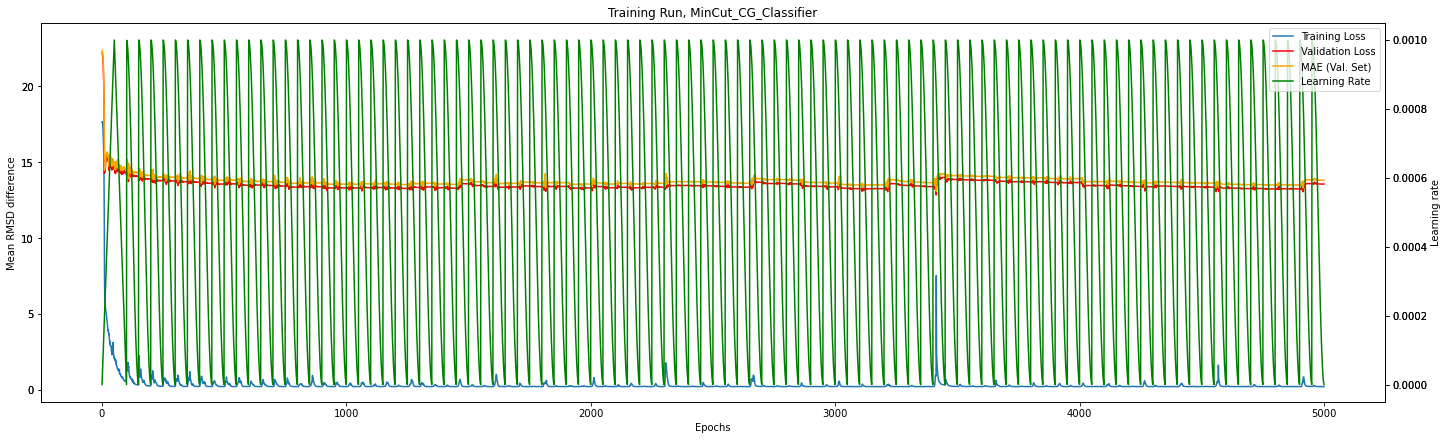

In [2]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"

#with th.autograd.detect_anomaly():
training(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=5_000,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    #num_workers=0,
    #resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=100)

In [3]:
#get training run data

run_dir = "run_data/2022-06-22_15-5_MinCut_CG_Classifier"
burn_in = 100

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.2250 in epoch 4547
Minimum Validation Loss (after 100 epochs) 12.8420 in epoch 3413
Minimum MAE (after 100 epochs) 13.0861 in epoch 3413


Validation Loss at 3413 is 12.8420
5 before select
13.6982, 13.3118, 13.6717, 12.9251, 13.6789
5 after select
13.5131, 13.4778, 13.7369, 13.8288, 13.8220
MAE at 3413 is 13.0861


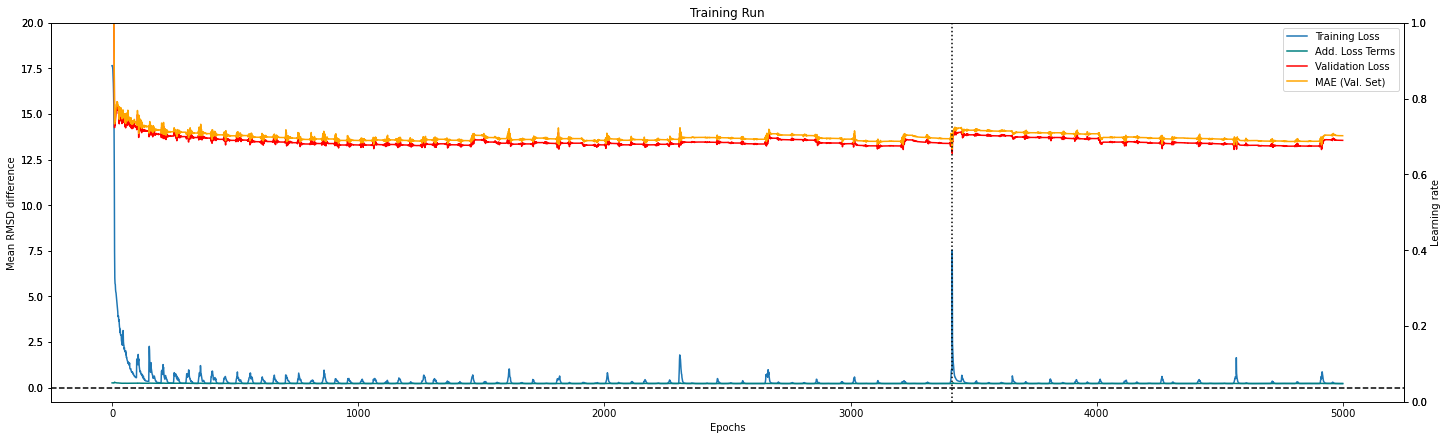

In [4]:
#plot the training run
select = 3413

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ybound(lower=(min(epoch_losses)-1), upper=20)#max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0, c = "black", ls = "--")

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 3413
Test Set
Minimum Loss: Label = 25.5360, Prediction = 25.5429, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 27.1691, Loss = 26.6691
Mean Test loss: 	 9.7558
Std. Dev. of Test loss:  5.7012
Min loss: 		 0.0000
First Quantile: 	 5.6016
Median: 		 9.4404
Third Quantile: 	 12.8296
Max Loss: 		 26.6691
LinregressResult(slope=0.955087068761293, intercept=-0.5203883518278118, rvalue=0.3806199284718586, pvalue=5.5832906318648215e-11, stderr=0.13992675985176167, intercept_stderr=2.6351277000428004)


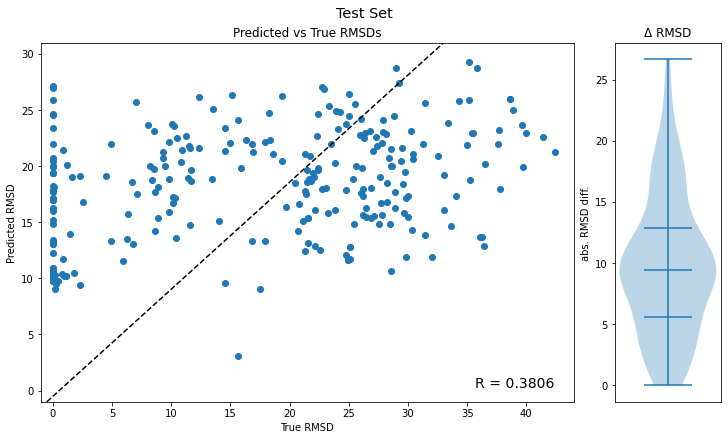

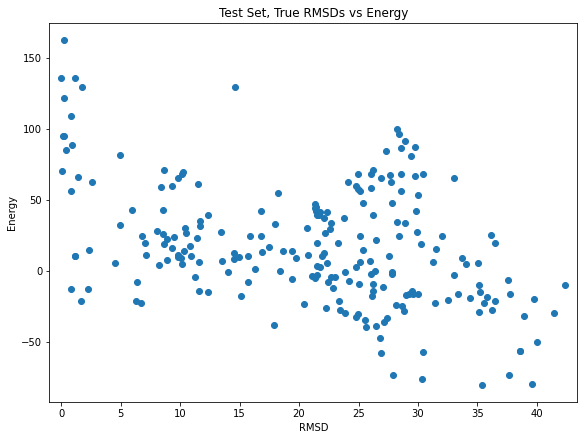

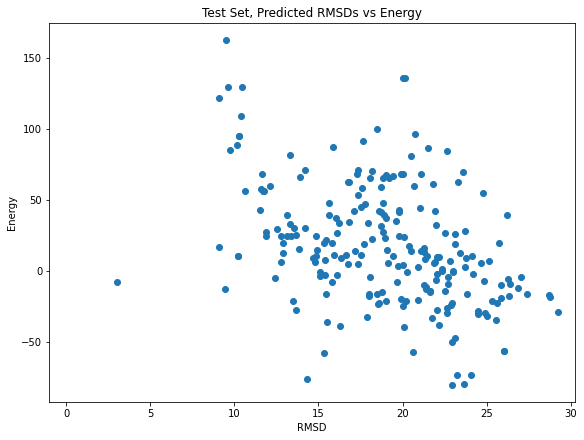

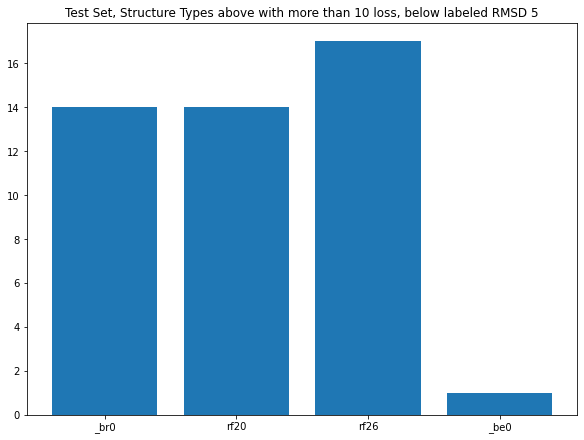

Prediction below 0: Label 3.5120, Pred -0.7494
5S and tRNA Test Set
Minimum Loss: Label = 26.5550, Prediction = 26.5559, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 25.5284, Loss = 25.0284
Mean Test loss: 	 4.8961
Std. Dev. of Test loss:  5.3029
Min loss: 		 0.0000
First Quantile: 	 1.2504
Median: 		 3.1706
Third Quantile: 	 6.3066
Max Loss: 		 25.0284
LinregressResult(slope=0.8422654545635917, intercept=0.5781374975649829, rvalue=0.5998748007912048, pvalue=7.971193934460881e-107, stderr=0.034167757295788, intercept_stderr=0.6581711890024717)


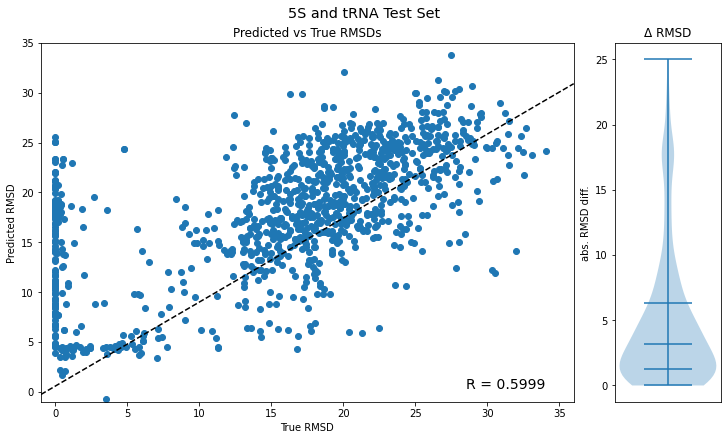

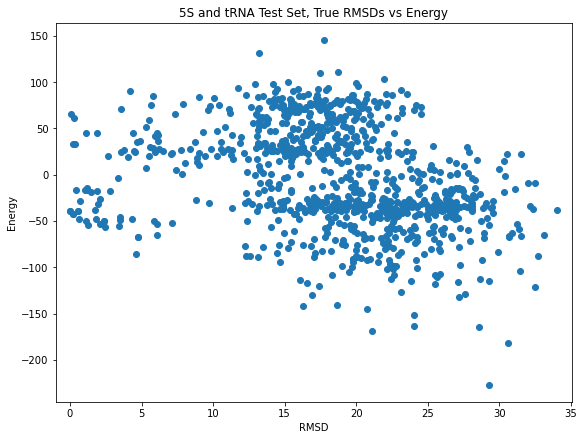

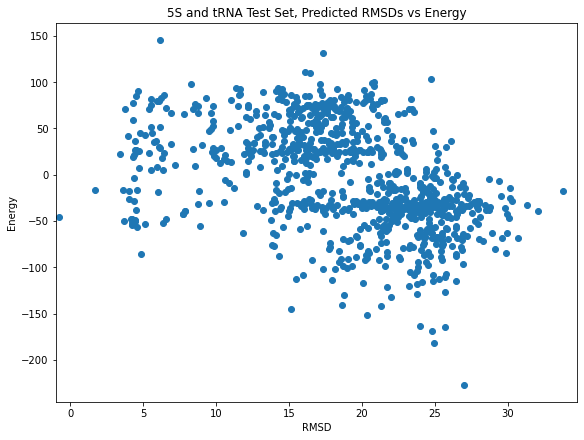

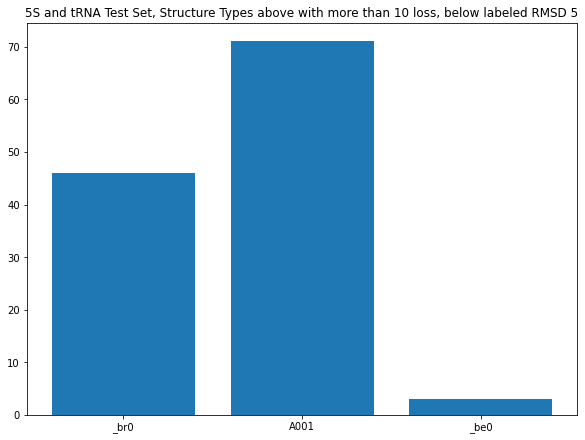

Training Set
Minimum Loss: Label = 30.2070, Prediction = 30.2002, Loss = 0.0000
Maximum Loss: Label = 0.1570, Prediction = 19.4891, Loss = 18.8321
Mean Test loss: 	 2.4164
Std. Dev. of Test loss:  3.4260
Min loss: 		 0.0000
First Quantile: 	 0.2375
Median: 		 1.0993
Third Quantile: 	 3.1459
Max Loss: 		 18.8321
LinregressResult(slope=1.068696947619979, intercept=-1.5958234738013992, rvalue=0.8746516150805715, pvalue=1.3926800849704613e-240, stderr=0.021513175503718947, intercept_stderr=0.4244064427271091)


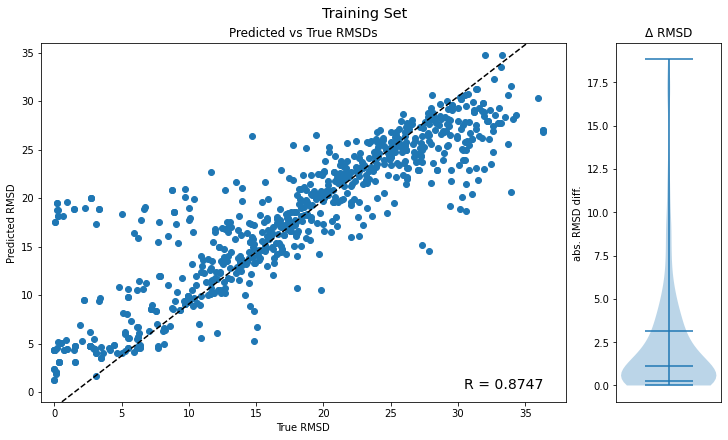

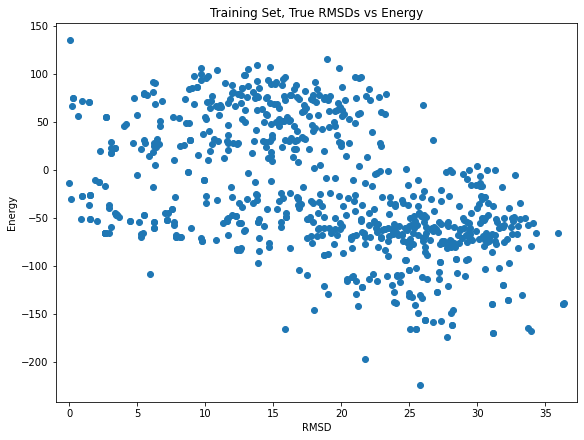

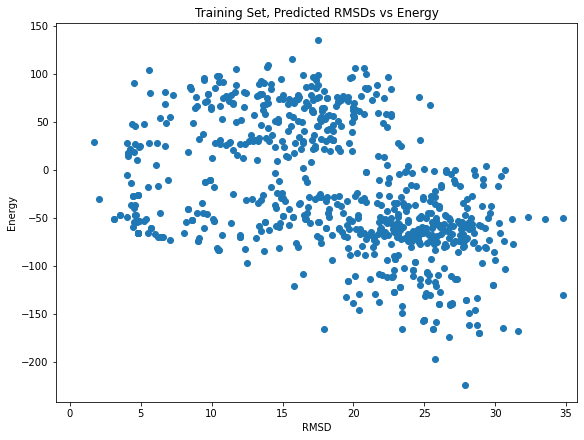

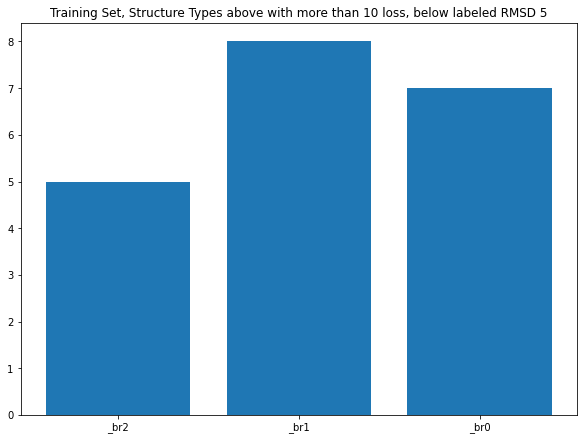

Validation Set
Minimum Loss: Label = 14.5020, Prediction = 14.4762, Loss = 0.0003
Maximum Loss: Label = 60.2560, Prediction = 12.3662, Loss = 47.3898
Mean Test loss: 	 12.6873
Std. Dev. of Test loss:  9.1734
Min loss: 		 0.0003
First Quantile: 	 5.1732
Median: 		 12.1617
Third Quantile: 	 18.6375
Max Loss: 		 47.3898
LinregressResult(slope=0.5734123894217167, intercept=11.092694716331478, rvalue=0.17469551509736658, pvalue=0.0004788815459654643, stderr=0.16281970504535986, intercept_stderr=3.541267157248471)


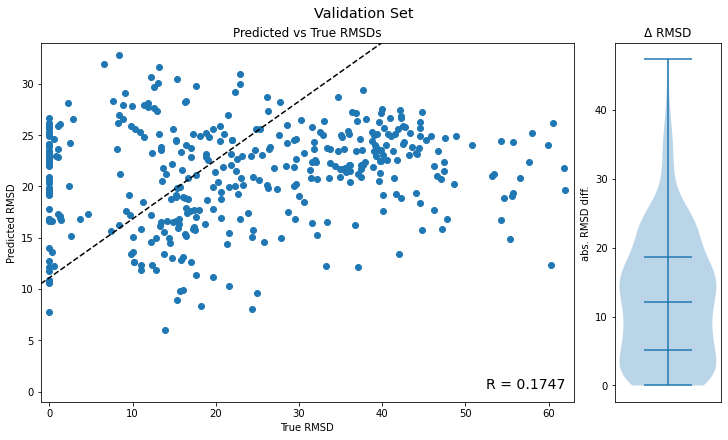

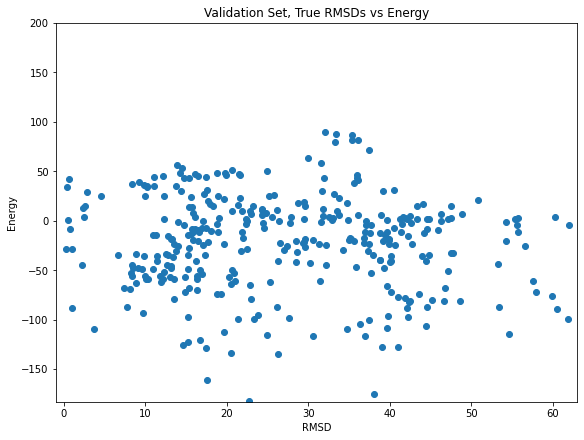

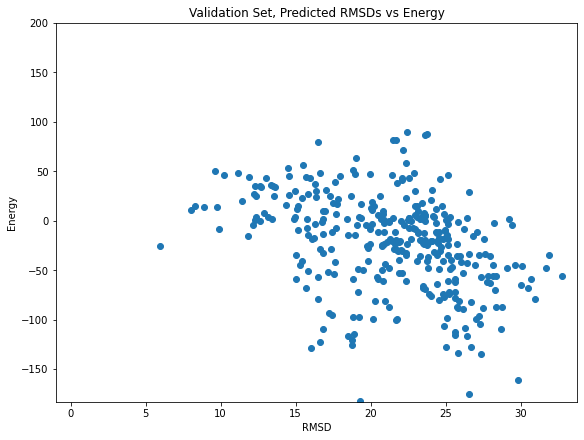

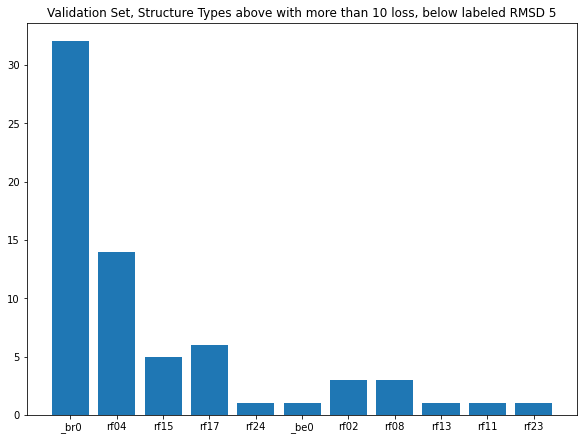

LinregressResult(slope=0.7489577327266117, intercept=6.24945757251373, rvalue=0.4283419477813108, pvalue=1.3896410372985485e-67, stderr=0.04094525790854292, intercept_stderr=0.83093943668013)


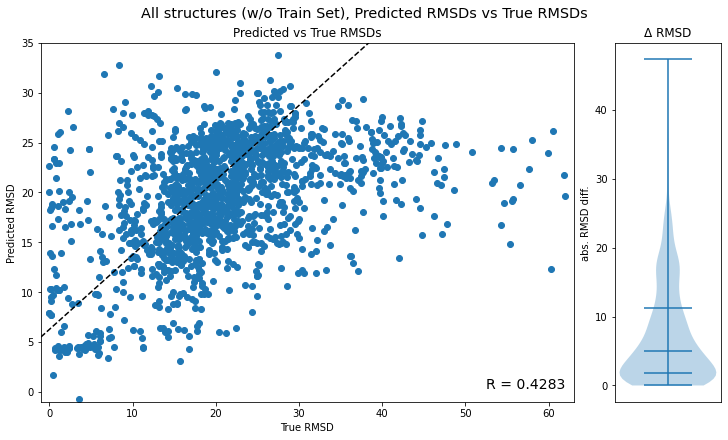

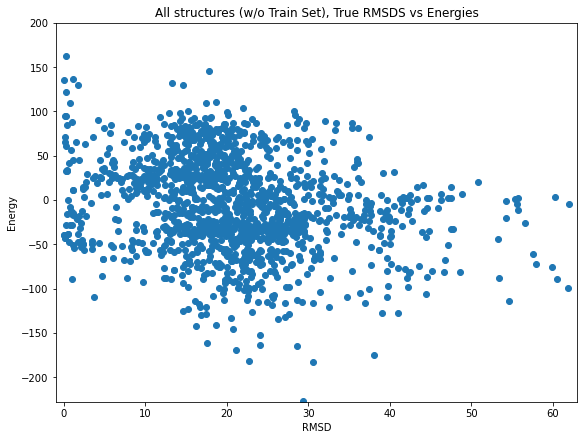

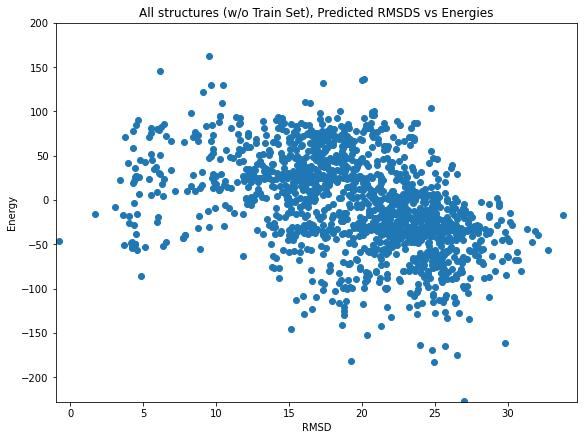

In [5]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

if "model" not in globals():
    print("Model not in global variables")
    model = MinCut_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9091579813203675, intercept=1.8185265564939073, rvalue=0.9366382501401529, pvalue=2.694587713881415e-127, stderr=0.020504017003080147, intercept_stderr=0.40753690556040806)


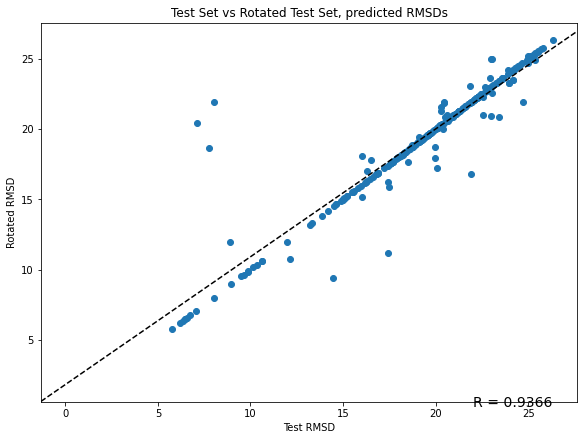

LinregressResult(slope=0.9786476636103387, intercept=0.3422918149869716, rvalue=0.9785232101141297, pvalue=1.2132055836684666e-190, stderr=0.012432089962595764, intercept_stderr=0.168440886827594)


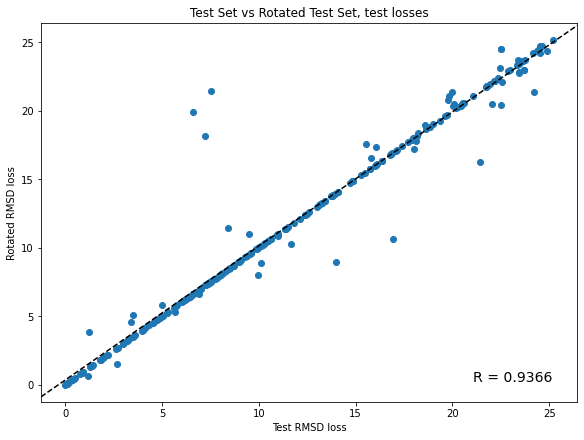

LinregressResult(slope=0.9712626165796127, intercept=0.5077173948013183, rvalue=0.9651781637725774, pvalue=0.0, stderr=0.00800650792132218, intercept_stderr=0.15077171482414378)


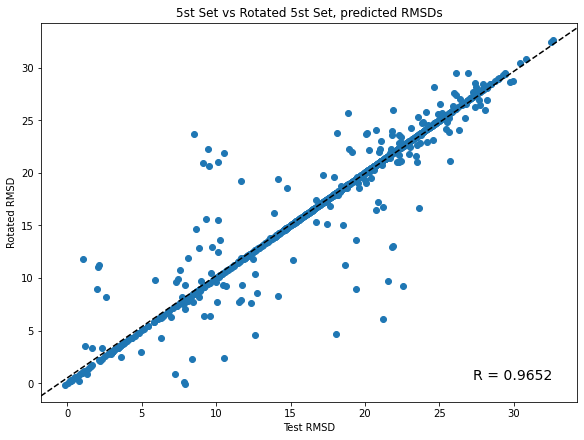

LinregressResult(slope=0.9253551594236874, intercept=0.29146281014302033, rvalue=0.9308669272310164, pvalue=0.0, stderr=0.011046561261775974, intercept_stderr=0.07107113242709055)


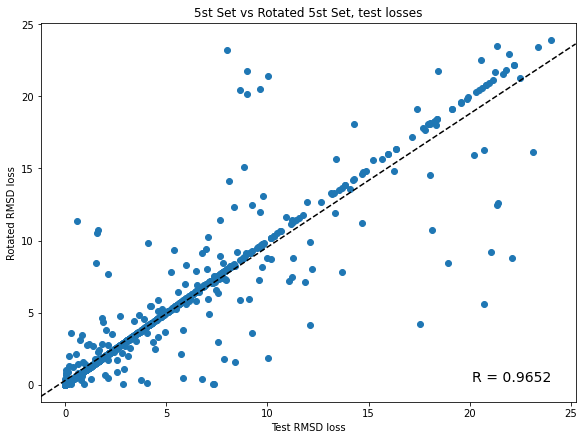

In [20]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")